In [1]:
import os
import cv2
import json
import torch
import skimage
import scipy.misc
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from copy import deepcopy
from pprint import pprint
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader

### Example Annotation

In [2]:
annotation_path = "/Users/shashanks./college/rrc/dataset/mpii/annot/train.json"
dataset_path = "/Users/shashanks./college/rrc/dataset/mpii/images"

with open(annotation_path, 'r') as f:
    annotation_json = json.load(f)

pprint(annotation_json[0])

{'center': [594.0, 257.0],
 'image': '015601864.jpg',
 'joints': [[620.0, 394.0],
            [616.0, 269.0],
            [573.0, 185.0],
            [647.0, 188.0],
            [661.0, 221.0],
            [656.0, 231.0],
            [610.0, 187.0],
            [647.0, 176.0],
            [637.0201, 189.8183],
            [695.9799, 108.1817],
            [606.0, 217.0],
            [553.0, 161.0],
            [601.0, 167.0],
            [692.0, 185.0],
            [693.0, 240.0],
            [688.0, 313.0]],
 'joints_vis': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'scale': 3.021046}


### Display image & bounding box

In [3]:
idx = 5432
# idx = 4356
img_path = os.path.join(dataset_path, annotation_json[idx]['image'])
img = io.imread(img_path)

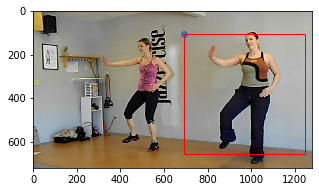

In [4]:
center = annotation_json[idx]['center']
scale = annotation_json[idx]['scale']

# Adjust center/scale slightly to avoid cropping limbs
if center[0] != -1:
    center[1] = center[1] + 15 * scale
    scale = scale * 1.25

scale = scale * 200.0

x, y = int(center[0] - scale / 2.0), int(center[1] - scale / 2.0)
w, h = int(scale), int(scale)

fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(1, 1, 1)

ax1.imshow(img)

# Create a Rectangle patch
rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
plt.scatter([x], [y])

# Add the patch to the Axes
ax1.add_patch(rect)
plt.show()

In [5]:
def get_transform(center, scale, res, rot=0):
    # Generate transformation matrix
    h = 200 * scale
    t = np.zeros((3, 3))
    t[0, 0] = float(res[1]) / h
    t[1, 1] = float(res[0]) / h
    t[0, 2] = res[1] * (-float(center[0]) / h + .5)
    t[1, 2] = res[0] * (-float(center[1]) / h + .5)
    t[2, 2] = 1
    if not rot == 0:
        rot = -rot # To match direction of rotation from cropping
        rot_mat = np.zeros((3,3))
        rot_rad = rot * np.pi / 180
        sn,cs = np.sin(rot_rad), np.cos(rot_rad)
        rot_mat[0,:2] = [cs, -sn]
        rot_mat[1,:2] = [sn, cs]
        rot_mat[2,2] = 1
        # Need to rotate around center
        t_mat = np.eye(3)
        t_mat[0,2] = -res[1]/2
        t_mat[1,2] = -res[0]/2
        t_inv = t_mat.copy()
        t_inv[:2,2] *= -1
        t = np.dot(t_inv,np.dot(rot_mat,np.dot(t_mat,t)))
    return t

In [6]:
def transform(pt, center, scale, res, invert=0, rot=0):
    # Transform pixel location to different reference
    t = get_transform(center, scale, res, rot=rot)
    if invert:
        t = np.linalg.inv(t)
    new_pt = np.array([pt[0], pt[1], 1.]).T
    new_pt = np.dot(t, new_pt)
    return new_pt[:2].astype(int)

In [7]:
ul = np.array(transform([0, 0], center, scale / 200, (256, 256), invert=1))
ul

array([694, 104])

In [8]:
br = np.array(transform([256, 256], center, scale / 200, (256, 256), invert=1))
br

array([1249,  658])

In [9]:
new_shape = [br[1] - ul[1], br[0] - ul[0]]
if len(img.shape) > 2:
    new_shape += [img.shape[2]]
new_img = np.zeros(new_shape)

# Range to fill new array
new_x = max(0, -ul[0]), min(br[0], len(img[0])) - ul[0]
new_y = max(0, -ul[1]), min(br[1], len(img)) - ul[1]
# Range to sample from original image
old_x = max(0, ul[0]), min(len(img[0]), br[0])
old_y = max(0, ul[1]), min(len(img), br[1])
new_img[new_y[0]:new_y[1], new_x[0]:new_x[1]] = img[old_y[0]:old_y[1], old_x[0]:old_x[1]]
new_img.shape

(554, 555, 3)

In [10]:
new_img = skimage.transform.resize(new_img, (256, 256)).astype(np.uint8)
new_img.shape

(256, 256, 3)

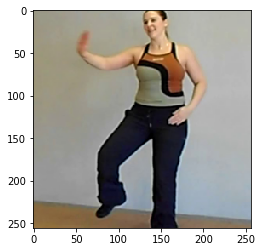

In [11]:
cropped = deepcopy(new_img)
plt.imshow(cropped)

In [12]:
keypoints = np.array(annotation_json[idx]['joints'])
keypoints = keypoints - [x, y]
keypoints = keypoints * 256 / scale

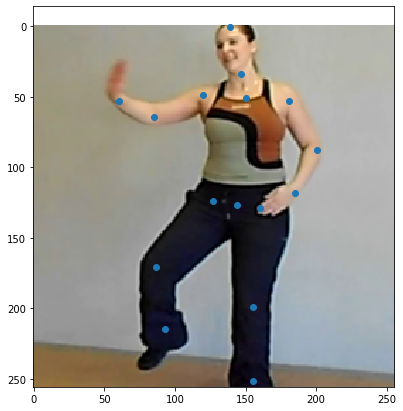

In [13]:
fig = plt.figure(figsize=(7, 7))
ax1 = fig.add_subplot(1, 1, 1)

ax1.imshow(cropped)
ax1.scatter(keypoints[:, 0], keypoints[:, 1])
plt.show()

In [14]:
annotation_json[idx]['joints_vis']

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [20]:
height, width = cropped.shape[0:2]
center = np.array((width/2, height/2))
scale = max(height, width)/200
height, width, center, scale

(256, 256, array([128., 128.]), 1.28)

In [21]:
# aug_rot = (np.random.random() * 2 - 1) * 30.
# aug_scale = np.random.random() * (1.25 - 0.75) + 0.75
aug_scale = 1.2
aug_rot = 25
scale *= aug_scale
aug_rot, scale

(25, 1.536)

In [22]:
center, scale * 200, (64, 64), aug_rot

(array([128., 128.]), 307.2, (64, 64), 25)

In [23]:
mat_mask = get_transform(center, scale, (64, 64), aug_rot)[:2]
mat_mask

array([[ 0.18881412,  0.08804547, -3.43802797],
       [-0.08804547,  0.18881412, 19.10161266]])

In [24]:
mat = get_transform(center, scale, (256, 256), aug_rot)[:2]
mat

array([[  0.75525649,   0.35218188, -13.75211187],
       [ -0.35218188,   0.75525649,  76.40645064]])

In [25]:
def kpt_affine(kpt, mat):
    kpt = np.array(kpt)
    shape = kpt.shape
    kpt = kpt.reshape(-1, 2)
    return np.dot( np.concatenate((kpt, kpt[:, 0:1]*0+1), axis = 1), mat.T ).reshape(shape)

In [26]:
inp = cv2.warpAffine(cropped, mat, (256, 256)).astype(np.uint8)

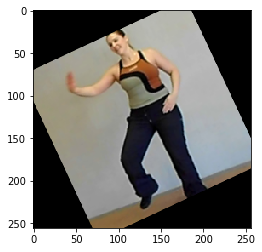

In [27]:
inp = inp.astype(np.uint8)
plt.imshow(inp)

In [28]:
keypoints

array([[ 92.79623592, 214.21618641],
       [ 86.79448932, 170.35726893],
       [126.96002427, 123.72831457],
       [160.20046699, 128.80671554],
       [155.12206602, 198.9809835 ],
       [155.58373884, 251.61168447],
       [143.58024563, 126.49835146],
       [150.50533787,  50.78400971],
       [146.55304923,  33.92870455],
       [138.76075078,   0.69675661],
       [ 60.47913884,  52.63070097],
       [ 85.40947088,  64.17252136],
       [120.03493204,  48.93731845],
       [180.51407088,  52.63070097],
       [200.36600194,  87.71783495],
       [185.13079903, 118.18824078]])

In [31]:
kp1 = np.c_[keypoints, np.ones(len(keypoints))]

In [32]:
kp2 = np.dot(kp1, mat.T).reshape(keypoints.shape)
kp2

array([[131.77590777, 205.51346224],
       [111.79673348, 174.50243664],
       [125.71014136, 125.14004247],
       [152.60372225, 117.26885599],
       [173.48233292, 172.05694807],
       [192.36659377, 211.6440337 ],
       [139.2382282 , 121.37878992],
       [117.80322947,  61.75614996],
       [108.88210469,  50.41799582],
       [ 91.29323066,  28.06365785],
       [ 50.46072966,  94.85647197],
       [ 73.35434477,  94.79349539],
       [ 94.13988653,  71.09254935],
       [141.11789102,  52.58234336],
       [168.46824376,  72.09063849],
       [167.69288285, 100.4691727 ]])

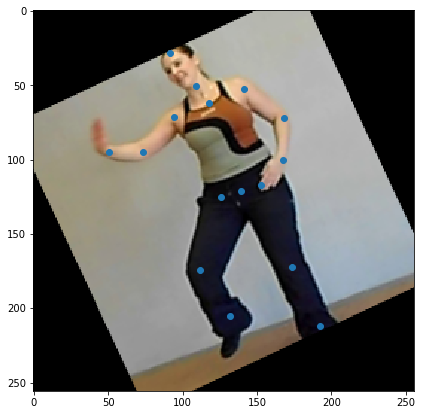

In [33]:
fig = plt.figure(figsize=(7, 7))
ax1 = fig.add_subplot(1, 1, 1)

ax1.imshow(inp)
ax1.scatter(kp2[:, 0], kp2[:, 1])
plt.show()

In [ ]:
row, col = y, x
cropped_image = img[row:row + h, col:col + w]
plt.imshow(cropped_image)

### Draw Keypoints

In [ ]:
joints = np.array(annotation_json[idx]['joints'])
joints = joints - [x, y]
joints

In [ ]:
fig = plt.figure(figsize=(7, 7))
ax1 = fig.add_subplot(1, 1, 1)

ax1.imshow(inp)
ax1.scatter(kp2[:, 0], kp2[:, 1])
plt.show()

### Rescale transform

In [ ]:
class Rescale(object):
    """
    Rescale an image and the corresponding keypoints to the given output size
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
    
    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']
        
        h, w = image.shape[:2]
        new_h, new_w = int(self.output_size), int(self.output_size)
        
        img = transform.resize(image, (new_h, new_w)) # Use skimage inbuilt function
        keypoints = keypoints * [new_w / w, new_h / h]
        
        return {'image': img, 'keypoints': keypoints}

In [ ]:
scale = Rescale(output_size=256)
new_sample = scale({"image": cropped_image, "keypoints": joints})

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)

ax1.imshow(new_sample['image'])
ax1.scatter(new_sample['keypoints'][:, 0], new_sample['keypoints'][:, 1])
plt.show()

In [ ]:
# img = cv2.imread(img_path)[:,:,::-1]
# plt.imshow(img)

In [ ]:
import cv2
import numpy as np

class RandomHorizontalFlip(object):
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, sample):
        img, keypoints, visible_keypoints = sample["image"], sample["keypoints"], sample["visible_keypoints"]
        img_center = np.array(img.shape[:2])[::-1] / 2
        
        if random.random() < self.p:
            img =  img[:, ::-1, :]
            keypoints[:, :2] += 2 * 
            bboxes[:,[0,2]] += 2*(img_center[[0,2]] - bboxes[:,[0,2]])
        
        return img_center

In [ ]:
joints.shape

In [ ]:
sample = {"image": cropped_image, "keypoints": joints, "visible_keypoints": annotation_json[idx]["joints_vis"]}

In [ ]:
r = RandomHorizontalFlip()
im = r(sample)

In [ ]:
im

In [ ]:
cropped_image.shape

### Affine Transforms

In [ ]:
img_path = '/Users/shashanks./Desktop/messi.jpg'
img = cv2.imread(img_path)[:,:,::-1]
# img = deepcopy(cropped)
plt.imshow(img)

### Translate all points to the center of the image

In [ ]:
rows, cols, _ = img.shape
M = np.float32([[1, 0, - cols / 2], [0, 1, - rows / 2]])
dst = cv2.warpAffine(img, M, (cols, rows)).astype(np.uint8)
rows, cols

In [ ]:
plt.scatter([cols / 2], [rows / 2], s=50)
plt.imshow(dst)

### Scale by aug_scale * max(H, W)

In [ ]:
aug_scale = 0.4 * max(rows, cols)
M = np.float32([[1, 0, - cols / 2], [0, 1, - rows / 2], [0, 0, 1]])
N = np.float32([[aug_scale / cols, 0, 0], [0, aug_scale / rows, 0], [0, 0, 1]])
T1 = np.dot(N, M)

In [ ]:
dst = cv2.warpAffine(img, T1[:2, :], (cols, rows)).astype(np.uint8)
plt.imshow(dst)
plt.scatter([cols / 2], [rows / 2], s=50)
plt.scatter([(aug_scale / cols) * cols / 2], [(aug_scale / rows) * rows / 2], s=50)

In [ ]:
aug_scale

### Scale to a resolution size res

In [ ]:
res = 256
T2 = np.float32([[res / aug_scale, 0, 0], [0, res / aug_scale, 0], [0, 0, 1]])
T3 = np.float32([[1, 0, res / 2], [0, 1, res / 2], [0, 0, 1]])
T4 = np.dot(T3, np.dot(T2, T1))

In [ ]:
dst = cv2.warpAffine(img, T4[:2, :], (256, 256)).astype(np.uint8)
plt.imshow(dst)
# plt.scatter([cols / 2], [rows / 2], s=50)
# plt.scatter([(aug_scale / 450) * cols / 2], [(aug_scale / 280) * rows / 2], s=50)

In [ ]:
M = np.float32([[1, 0, - cols / 2], [0, 1, - rows / 2], [0, 0, 1]])
N = np.float32([[450 / (1.2 * 450), 0, 0], [0, 280 / (1.2 * 450), 0], [0, 0, 1]])
T1 = np.dot(N, M)
T1

In [ ]:
dst = cv2.warpAffine(img, T1[:2, :], (cols, rows)).astype(np.uint8)
plt.imshow(dst)

In [ ]:
T1

In [ ]:
O = np.float32([[1, 0, cols / 2], [0, 1, rows / 2], [0, 0, 1]])
T2 = np.dot(O, T1)
dst = cv2.warpAffine(img, T2[:2, :], (cols, rows)).astype(np.uint8)
plt.imshow(dst)

In [ ]:
M = np.float32([[1, 0, - cols / 2], [0, 1, - rows / 2], [0, 0, 1]])
N = np.float32([[0.8 * 450 / 450, 0, 0], [0, 0.8 * 450 / 280, 0], [0, 0, 1]])
T1 = np.dot(N, M)
T1

In [ ]:
dst = cv2.warpAffine(img, T1[:2, :], (cols, rows)).astype(np.uint8)
plt.imshow(dst)

In [ ]:
O = np.float32([[1, 0, cols / 2], [0, 1, rows / 2], [0, 0, 1]])
T2 = np.dot(O, T1)
dst = cv2.warpAffine(img, T2[:2, :], (cols, rows)).astype(np.uint8)
plt.imshow(dst)

In [ ]:
# cols-1 and rows-1 are the coordinate limits.
M = cv2.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),32,1)
dst = cv2.warpAffine(img,M, (cols,rows))

In [ ]:
plt.imshow(dst)

In [ ]:
img.shape

In [ ]:
dst.shape